## 02 ECAPA Exploration 

A notebook for exploring ECAPA on the PVQD dataset.

What if I told you it was just as easy as swapping out which model is loaded?

(Didn't even bother to change all the variable names!)

In [19]:
import os 
import glob 
from IPython.display import Audio 

# Import to add src/ to the path
import sys 
sys.path.append('../')

from src.utils import extract_speaker, process_diagnosis, process_age

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import torch 
import torchaudio 

# run `pip install speechbrain` to download this package 
from speechbrain.pretrained import EncoderClassifier

# Depending on Version, might be:
# from speechbrain.inference.speaker import EncoderClassifier

# Import TSNE for Visualization
from sklearn.manifold import TSNE

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load in the X-Vector Classifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"})

In [21]:
# Load in all the files and extract the speaker
audio_files = glob.glob('../data/pvqd_matched/*/*.wav')
speakers = [extract_speaker(x.split('/')[-2]) for x in audio_files] # Extract the Speaker from each audio file
print(f"Number of Audio Files: {len(audio_files)}")
print(f"Number of Speakers: {len(np.unique(speakers))}")

# Load in the Demographics File
demo_df = pd.read_csv('../data/demographics.csv')

# Get binary of whether or not speaker is healthy (or has Diagnosis) and get Age Bracket
demo_df["has_diagnosis"] = demo_df["Diagnosis "].map(process_diagnosis)
demo_df["age_bracket"] = demo_df["Age"].map(process_age)

# Process the gender column, let's just make gender either a 'm' or 'f' value
lowered_gender = demo_df["Gender"].str.lower()

gender_dict = {
    "female": "f",
    "male": "m",
    'm': 'm',
    "f": 'f'
}

lowered_gender = lowered_gender.map(gender_dict)

demo_df["Gender"] = lowered_gender

print(demo_df.head())

Number of Audio Files: 1117
Number of Speakers: 280
  Participant ID  Gender  Age Diagnosis  has_diagnosis age_bracket
0            BL01      m   46        NaN           NaN  Middle Age
1            BL02      f   76        NaN           NaN      Senior
2            BL03      f   88        NaN           NaN      Senior
3            BL04      f   42        NaN           NaN  Middle Age
4            BL05      f   75        NaN           NaN      Senior


In [4]:
demo_df[['has_diagnosis', 'Gender']].groupby('has_diagnosis').count()

,Gender
has_diagnosis,
N,89
Y,188


In [5]:
# Play an example audio file
Audio(audio_files[1])

### Extracting the ECAPA-TDNN Embedding

In [6]:
x_vectors = [] 

for audio_path in audio_files:
    signal, fs = torchaudio.load(audio_path)
    signal = signal.to(device)
    embeddings = classifier.encode_batch(signal)
    embeddings = embeddings.flatten()

    x_vectors.append(embeddings.cpu().numpy())

x_vectors = np.array(x_vectors)
print(f"Extracted Embeddings of Shape: {x_vectors.shape}")

Extracted Embeddings of Shape: (1117, 192)


In [7]:
# Reduce the Embeddings down to something more manageable
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(x_vectors)
print(f"Dimension Reduced ECAPA-TDNN Embeddings' Shape: {X_embedded.shape}")

Dimension Reduced X-Vectors' Shape: (1117, 2)


### Let's Visualize the Results!!



In [22]:
# Create a Dataframe
xvect_df = pd.DataFrame({
    'Participant ID ': speakers,
    'P1': X_embedded[:, 0],
    'P2': X_embedded[:, 1],
})

# Link the Demo characteristics and the speaker
xvect_df = xvect_df.merge(demo_df[['Participant ID ', 'Gender', 'has_diagnosis', 'age_bracket']], how = 'left', on='Participant ID ')
print(xvect_df.head())

  Participant ID          P1         P2 Gender has_diagnosis age_bracket
0           PT121 -67.069679  15.670204      m             Y      Senior
1           PT121 -66.204605  15.607701      m             Y      Senior
2           PT121 -65.267815  15.515158      m             Y      Senior
3           PT121 -54.463646  16.360905      m             Y      Senior
4           PT040  32.696236  40.364929      f             Y       Teens


<Axes: xlabel='P1', ylabel='P2'>

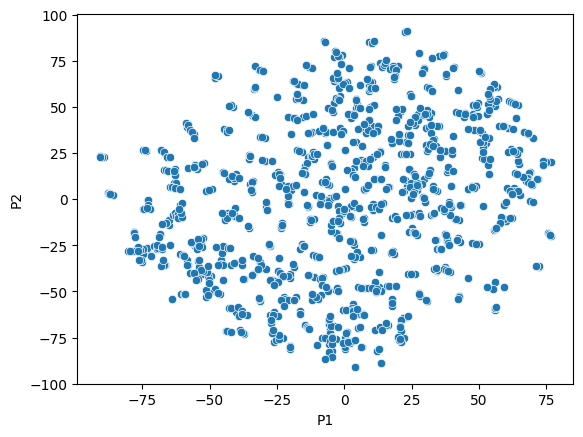

In [23]:
# Visualize the latent space
sns.scatterplot(data=xvect_df, x='P1', y='P2')

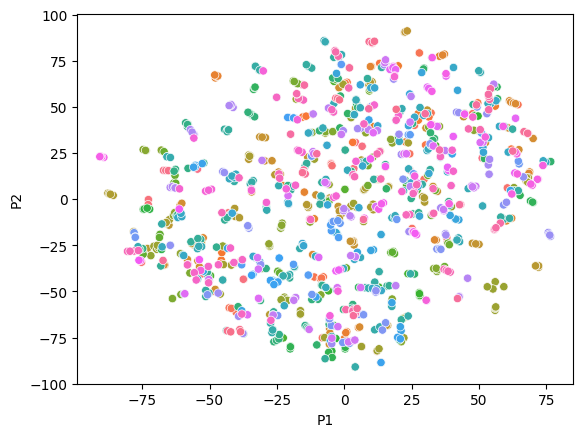

In [24]:
sns.scatterplot(data=xvect_df, x='P1', y='P2', hue = 'Participant ID ')
plt.legend([],[], frameon=False) # This just hides the legend

<Axes: xlabel='P1', ylabel='P2'>

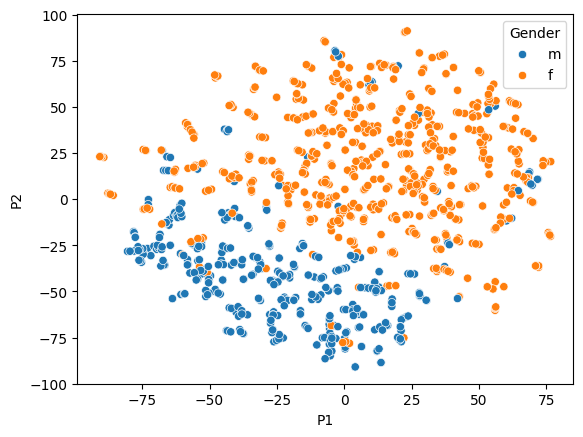

In [25]:
# Split by Gender
sns.scatterplot(data=xvect_df, x='P1', y='P2', hue = 'Gender')

<Axes: xlabel='P1', ylabel='P2'>

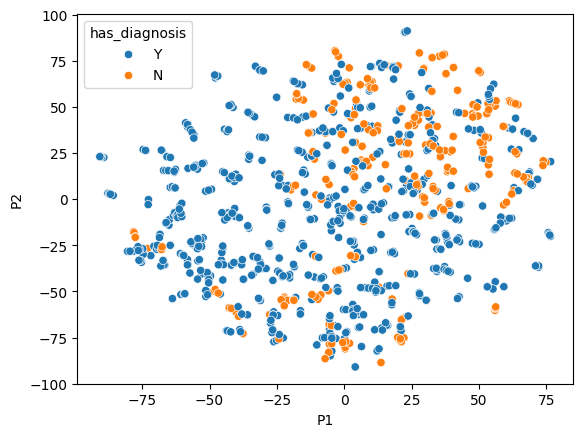

In [26]:
# Split by Diagnosis
sns.scatterplot(data=xvect_df, x='P1', y='P2', hue = 'has_diagnosis')

<Axes: xlabel='P1', ylabel='P2'>

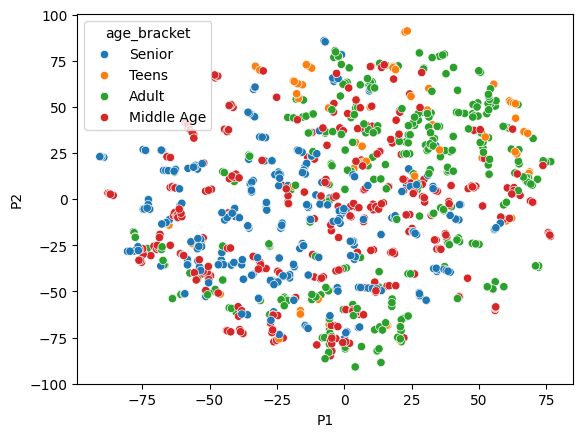

In [28]:
# Split by Age
sns.scatterplot(data=xvect_df, x='P1', y='P2', hue = 'age_bracket')

<Axes: xlabel='P1', ylabel='P2'>

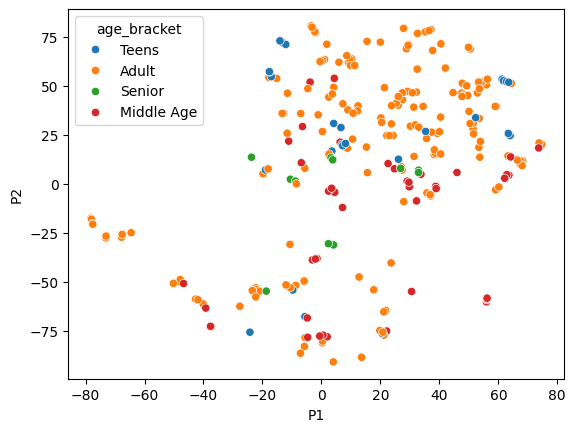

In [29]:
# Remove those with Diagnoses
sub_df = xvect_df[xvect_df['has_diagnosis'] == 'N']
sns.scatterplot(data=sub_df, x='P1', y='P2', hue = 'age_bracket')

<Axes: xlabel='P1', ylabel='P2'>

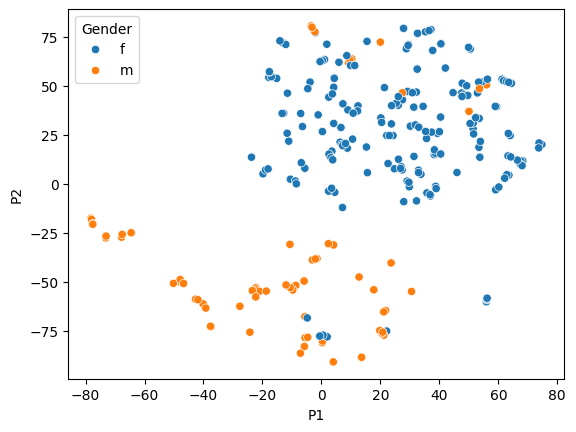

In [30]:
sns.scatterplot(data=sub_df, x='P1', y='P2', hue = 'Gender')